<a href="https://colab.research.google.com/github/GermanM3/GermanM3/blob/master/Intraday_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
from google.colab import files
uploaded = files.upload()

Saving K200_Intra.xlsx to K200_Intra.xlsx


In [107]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd, BDay
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

In [108]:
df_intra = pd.read_excel("K200_Intra.xlsx")
df_intra['Date'] = pd.to_datetime(df_intra['Date'])
df_intra.set_index('Date', inplace=True)
df_intra = df_intra.sort_index()

In [109]:
daily_groups = df_intra.groupby(df_intra.index.date)
date_boundary = pd.Timestamp('2023-07-31')

In [110]:
trading_signals = []

for date, day_data in daily_groups:
    if len(day_data) < 2:
        continue

    if pd.Timestamp(date) < date_boundary:
        open_time = pd.Timestamp(f'{date} 09:00:00')
        first_end = open_time + pd.Timedelta(minutes=30)
        last_start = pd.Timestamp(f'{date} 15:15:00')
        last_end = pd.Timestamp(f'{date} 15:45:00')
    else:
        open_time = pd.Timestamp(f'{date} 08:45:00')
        first_end = open_time + pd.Timedelta(minutes=30)
        last_start = pd.Timestamp(f'{date} 15:15:00')
        last_end = pd.Timestamp(f'{date} 15:45:00')

    first_window = day_data.loc[(day_data.index >= open_time) & (day_data.index <= first_end)]
    last_window = day_data.loc[(day_data.index >= last_start) & (day_data.index <= last_end)]

    if not first_window.empty and not last_window.empty:
        r1 = (first_window['Close'].iloc[-1] / first_window['Close'].iloc[0]) - 1
        r13 = (last_window['Close'].iloc[-1] / last_window['Close'].iloc[0]) - 1
        trading_signals.append({'date': date, 'r1': r1, 'r13': r13})

signals_df = pd.DataFrame(trading_signals)

In [122]:
backtest_results = []
for index, row in signals_df.iterrows():
    r1 = row['r1']
    r13 = row['r13']

    trade_profit = 0

    if r1 > 0:   # 장초 수익률 양수 → 마지막 30분 롱
        trade_profit = +r13
    elif r1 < 0: # 장초 수익률 음수 → 마지막 30분 숏
        trade_profit = -r13

    backtest_results.append({
        'Date': row['date'],
        'r1': r1,
        'r13': r13,
        'profit': trade_profit
    })

results_df = pd.DataFrame(backtest_results)

In [123]:
# 성과 지표 계산
total_trades = len(results_df)
if total_trades > 0:
    winning_trades = len(results_df[results_df['profit'] > 0])
    win_rate = winning_trades / total_trades

    # 누적 수익률 (복리)
    cumulative_return = (1 + results_df['profit']).prod() - 1

    # CAGR (연환산)
    cagr = (1 + cumulative_return) ** (252 / total_trades) - 1

    # 샤프 비율 (일별 기준)
    mean_daily = results_df['profit'].mean()
    std_daily = results_df['profit'].std()
    sharpe_ratio = (mean_daily / std_daily) * np.sqrt(252) if std_daily > 0 else 0

    print("----- 백테스팅 결과 -----")
    print(f"총 거래 횟수: {total_trades}")
    print(f"승률: {win_rate * 100:.2f}%")
    print(f"누적 수익률: {cumulative_return * 100:.2f}%")
    print(f"CAGR: {cagr * 100:.2f}%")
    print(f"샤프 비율: {sharpe_ratio:.2f}")

    # --- 추가된 코드: 연도별, 월별 수익률 ---

    # 'date' 컬럼을 datetime 형식으로 변환 (연, 월 추출을 위해)
    results_df['Date'] = pd.to_datetime(results_df['Date'])
    results_df['year'] = results_df['Date'].dt.year
    results_df['month'] = results_df['Date'].dt.month

    # 연도별 수익률 계산
    yearly_returns = results_df.groupby('year')['profit'].apply(lambda x: (1 + x).prod() - 1)

    print("\n----- 연도별 수익률 -----")
    for year, ret in yearly_returns.items():
        print(f"  {year}년: {ret * 100:.2f}%")

     # 월별 수익률 계산
    monthly_returns = results_df.groupby(['year', 'month'])['profit'].apply(lambda x: (1 + x).prod() - 1)

    print("\n----- 월별 수익률 -----")
    for (year, month), ret in monthly_returns.items():
        print(f"  {year}년 {month:02d}월: {ret * 100:.2f}%")
    # 월별 총 수익률의 평균 계산
    mean_monthly_return = monthly_returns.mean()

    print("\n----- 월별 평균 수익률 -----")
    print(f"월별 평균 수익률: {mean_monthly_return * 100:.2f}%")

else:
    print("거래 데이터가 충분하지 않습니다.")

----- 백테스팅 결과 -----
총 거래 횟수: 770
승률: 43.64%
누적 수익률: -2.94%
CAGR: -0.97%
샤프 비율: -0.35

----- 연도별 수익률 -----
  2022년: -0.27%
  2023년: 3.71%
  2024년: -1.31%
  2025년: -4.92%

----- 월별 수익률 -----
  2022년 06월: 0.13%
  2022년 07월: -1.02%
  2022년 08월: 0.68%
  2022년 09월: -0.65%
  2022년 10월: -0.15%
  2022년 11월: 1.00%
  2022년 12월: -0.26%
  2023년 01월: 0.57%
  2023년 02월: 0.62%
  2023년 03월: 0.61%
  2023년 04월: 0.20%
  2023년 05월: -0.20%
  2023년 06월: -0.64%
  2023년 07월: 0.48%
  2023년 08월: 1.09%
  2023년 09월: 0.06%
  2023년 10월: -0.24%
  2023년 11월: 0.84%
  2023년 12월: 0.26%
  2024년 01월: 0.07%
  2024년 02월: 0.31%
  2024년 03월: -0.15%
  2024년 04월: 0.18%
  2024년 05월: -0.13%
  2024년 06월: -0.41%
  2024년 07월: -0.85%
  2024년 08월: -0.91%
  2024년 09월: 1.24%
  2024년 10월: 0.34%
  2024년 11월: -0.12%
  2024년 12월: -0.86%
  2025년 01월: -0.75%
  2025년 02월: -0.16%
  2025년 03월: -1.02%
  2025년 04월: -0.53%
  2025년 05월: -1.16%
  2025년 06월: -0.64%
  2025년 07월: -1.54%
  2025년 08월: 0.78%

----- 월별 평균 수익률 -----
월별 평균 수익률: -0.07%


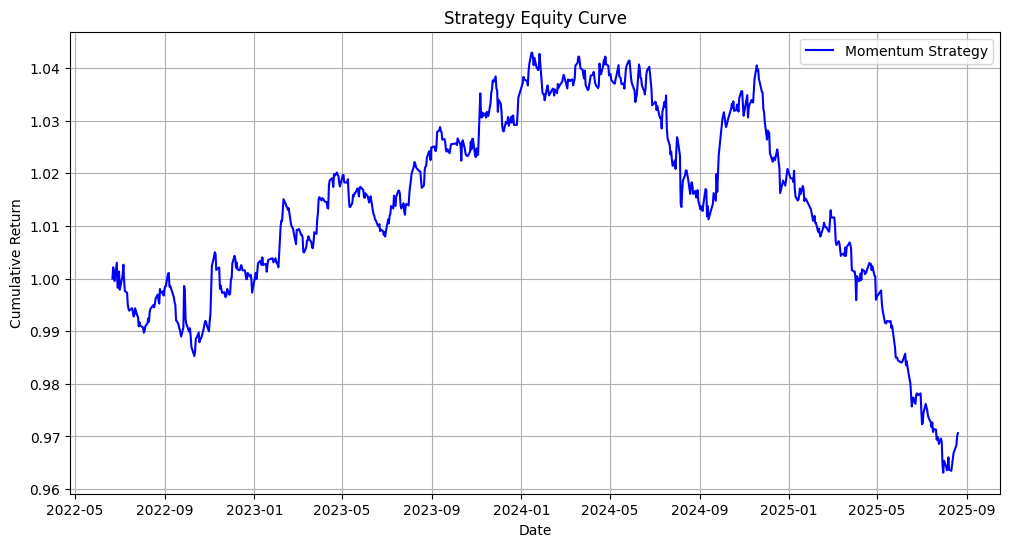

In [124]:
# 누적 수익률 계산
results_df['cumulative_return'] = (1 + results_df['profit']).cumprod()
results_df.loc[results_df.index[0], 'cumulative_return'] = 1

# 자산 곡선 시각화
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['cumulative_return'], label='Momentum Strategy', color='blue')
# plt.plot(benchmark_df['date'], benchmark_df['cumulative_return'], label='K200 Benchmark', color='gray', linestyle='--')

plt.title('Strategy Equity Curve')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()